# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

import string
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer

AttributeError: module 'numpy' has no attribute 'typeDict'

# Read text file

In [5]:
poem_file = open('../datasets/poem.txt','r')
poem = poem_file.read()

# Data Visualization

### Count Words

In [6]:
def count_words(text):
    # Maynot be correct word count
    count = text.count(" ") + 1
    print(f"Word Count: {count}")

def count_lines(text):
    count = text.count("\n") + 1
    print(f"Line Count: {count}")

### Word Cloud

Word Count: 17765
Line Count: 4092


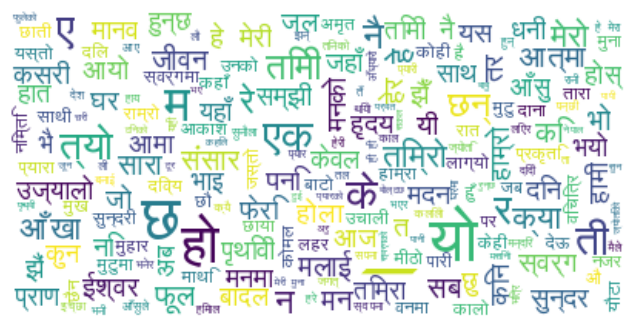

In [7]:
font_path = "../font/gargi.ttf"

wordlcloud = WordCloud(max_font_size = 50,
                       max_words = 200,
                       font_path = font_path,
                       background_color = 'white',
                       regexp=r"[\u0900-\u097F]+" ).generate(poem)

count_words(poem)
count_lines(poem)

plt.figure(figsize=(8,4))
plt.imshow(wordlcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### You can see the most frequent terms are stop-words.

# Preprocessing

### Split the corpus

In [8]:
poem_corpus = poem.split("\n")
print(poem_corpus[:5])

['नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,', 'मनको वनमा ननिभ्ने गरी विरह जलाई !', 'ननिभ्ने गरी विरह जलाई,', 'लोचनका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !', 'के भनूँ? भन्ने म केही थिइन  विष नै पिलाए !']


## Pre Process

In [9]:
def remove_noise(sentences):
    punctuations = ['\n','\ufeff','0','1','2','3','4','5','6','7','8','9','०','१','२','३','४','५','६','७','८','९','१०','।', ',', ';', '?', ' !', "”",' ! ' '!', '—', '-', '.',"’","‘","'","–",'\u200d']
    processed_sentences = []
    for sentence in sentences:
        for punct in punctuations:
            sentence = sentence.replace(punct,'')
        processed_sentences.append(sentence)

    return processed_sentences

In [10]:
processed_poem_corpus = remove_noise(poem_corpus)
print(processed_poem_corpus[:5])

['नछाडी जानोस् हे मेरा प्राण अकेली मलाई', 'मनको वनमा ननिभ्ने गरी विरह जलाई', 'ननिभ्ने गरी विरह जलाई', 'लोचनका तारा हे मेर प्यारा यो जोति  बिलाए', 'के भनूँ भन्ने म केही थिइन  विष नै पिलाए']


### **WordCloud**

Word Count: 17765
Line Count: 4092


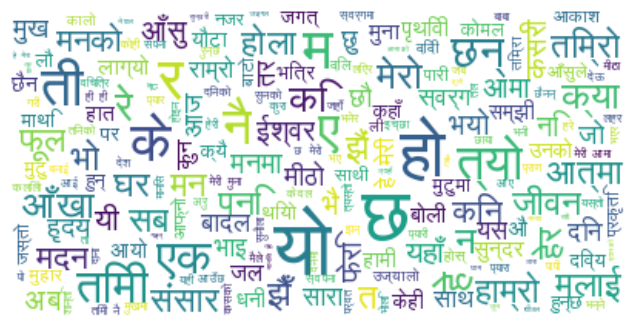

In [11]:
wordlcloud = WordCloud(max_font_size = 50,
                       max_words = 200,
                       font_path = font_path,
                       background_color = 'white',
                       regexp=r"[\u0900-\u097F]+" ).generate(''.join(processed_poem_corpus))

count_words(poem)
count_lines(poem)

plt.figure(figsize=(8,4))
plt.imshow(wordlcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

# **Using Tokenizer**

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_poem_corpus)
total_words = len(tokenizer.word_index) + 1

### Save Tokenizer for future Reference

In [13]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as json_file:
    json_file.write(tokenizer_json)

In [16]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
# Load the tokenizer from the JSON file
with open('tokenizer.json', 'r', encoding='utf-8') as json_file:
    tokenizer_json = json_file.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

In [20]:
tokenizer.word_index

{'छ': 1,
 'यो': 2,
 'हो': 3,
 'म': 4,
 'ती': 5,
 'के': 6,
 'र': 7,
 'एक': 8,
 'हे': 9,
 'तिमी': 10,
 'ए': 11,
 'नै': 12,
 'त्यो': 13,
 'रे': 14,
 'न': 15,
 'छन्': 16,
 'मेरो': 17,
 'मेरी': 18,
 'आमा': 19,
 'तिम्रो': 20,
 'क्या': 21,
 'आँखा': 22,
 'मलाई': 23,
 'भो': 24,
 'कि': 25,
 'आत्मा': 26,
 'मुना': 27,
 'सब': 28,
 'सारा': 29,
 'नि': 30,
 'संसार': 31,
 'मन': 32,
 'जीवन': 33,
 'फूल': 34,
 'घर': 35,
 'हामी': 36,
 'सुन्दर': 37,
 'मेरा': 38,
 'किन': 39,
 'झैँ': 40,
 'मदन': 41,
 'त': 42,
 'तर': 43,
 'यी': 44,
 'हेर': 45,
 'आज': 46,
 'मनको': 47,
 'होला': 48,
 'भाइ': 49,
 'पनि': 50,
 'यस': 51,
 'कुन': 52,
 'हाम्रो': 53,
 'जो': 54,
 'ईश्वर': 55,
 'फेरि': 56,
 'कसरी': 57,
 'आयो': 58,
 'ही': 59,
 'यहाँ': 60,
 'हृदय': 61,
 'मनमा': 62,
 'झैं': 63,
 'अब': 64,
 'मानिस': 65,
 'साथ': 66,
 'होस्': 67,
 'छौ': 68,
 'स्वर्ग': 69,
 'भै': 70,
 'आँसु': 71,
 'दिन': 72,
 'पृथिवी': 73,
 'साथी': 74,
 'बादल': 75,
 'हात': 76,
 'उज्यालो': 77,
 'हुन्छ': 78,
 'तिम्रा': 79,
 'दिदी': 80,
 'सम्झी': 81,
 'बाबा': 82,
 

In [23]:
# Converting the text into embeddings
input_sequences = []
for line in processed_poem_corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	# print(token_list)
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors, label = input_sequences[:, :-1], input_sequences[:, -1]

In [24]:
print(max_sequence_len)

11


In [13]:
print(processed_poem_corpus[0])
print(tokenizer.texts_to_sequences([processed_poem_corpus[0]]))
print(input_sequences[0])
print(predictors[0])
print(label[0])

नछाडी जानोस् हे मेरा प्राण अकेली मलाई
[[1336, 2629, 9, 38, 101, 627, 23]]
[   0    0    0    0    0    0    0    0    0 1336 2629]
[   0    0    0    0    0    0    0    0    0 1336]
2629


In [14]:
label = ku.to_categorical(label, num_classes=total_words+1)

In [15]:
predictors.shape

(14767, 10)

In [16]:
label.shape

(14767, 8582)

# Create LSTM model

In [17]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100,
					input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           858200    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 8581)              866681    
                                                                 
 dense_1 (Dense)             (None, 8582)              73650724  
                                                        

### **Train**

In [18]:
history = model.fit(predictors, label, epochs=250, verbose=1)

Epoch 1/250
462/462 [==============================] - 34s 50ms/step - loss: 8.7011 - accuracy: 0.0125
Epoch 2/250
462/462 [==============================] - 15s 32ms/step - loss: 8.2533 - accuracy: 0.0146
Epoch 3/250
462/462 [==============================] - 16s 34ms/step - loss: 8.0487 - accuracy: 0.0146
Epoch 4/250
462/462 [==============================] - 14s 31ms/step - loss: 7.9154 - accuracy: 0.0127
Epoch 5/250
462/462 [==============================] - 16s 34ms/step - loss: 7.7715 - accuracy: 0.0151
Epoch 6/250
462/462 [==============================] - 14s 31ms/step - loss: 7.6443 - accuracy: 0.0140
Epoch 7/250
462/462 [==============================] - 14s 31ms/step - loss: 7.5375 - accuracy: 0.0150
Epoch 8/250
462/462 [==============================] - 15s 32ms/step - loss: 7.4284 - accuracy: 0.0160
Epoch 9/250
462/462 [==============================] - 14s 31ms/step - loss: 7.3096 - accuracy: 0.0192
Epoch 10/250
462/462 [==============================] - 14s 31ms/step - l

### **Save Model**

In [19]:
model.save("nepali_lstm_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Test**

In [27]:
model = load_model("C:/Users/Ghost/Desktop/gits/Nepali_Poem_Generator/backend/models/LSTM/nepali_lstm.h5")

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
pip uninstall tensorflow
pip install tensorflow

In [20]:
seed_text = "मनको वनमा ननिभ्ने गरी विरह"
next_words = 20
ouptut_text = ""

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list,
                                        verbose=0), axis=-1)
    output_word = ""

    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    seed_text += " " + output_word

print(seed_text)

मनको वनमा ननिभ्ने गरी विरह जलाई कोल्टो लिएर बोल्न आँगनमा है ज्योतिको वनकाली पत्यार नाच्यो मन बादल घाम बाटो पृथिवी फेरि धारा जल चाला तिमी
